## 데이터 시각화
### 1. 데이터 분포 확인
### 2. 독립변수와 종속변수간의 상관관계 확인
### 3. 독립변수의 변수변환 후 종속변수와의 상관관계 확인
### 4. 상관관계가 0.4 이상인 변수만 추출

In [11]:
library(dplyr) 
library(ggplot2)
library(corrplot)

corrplot 0.84 loaded


### train 데이터의 입력 및 데이터 확인

In [84]:
tr <- read.csv('data/train.csv')
head(tr)

CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,MEDV
0.00632,18,2.31,0,0.538,6.575,65.2,4.0900,1,296,15.3,396.90,4.98,24.0
0.02731,0,7.07,0,0.469,6.421,78.9,4.9671,2,242,17.8,396.90,9.14,21.6
0.02729,0,7.07,0,0.469,7.185,61.1,4.9671,2,242,17.8,392.83,4.03,34.7
0.03237,0,2.18,0,0.458,6.998,45.8,6.0622,3,222,18.7,394.63,2.94,33.4
0.06905,0,2.18,0,0.458,7.147,54.2,6.0622,3,222,18.7,396.90,5.33,36.2
0.02985,0,2.18,0,0.458,6.430,58.7,6.0622,3,222,18.7,394.12,5.21,28.7


### 오른쪽 꼬리 분포를 나타냄
### 오른쪽 꼬리 분포지만 50에 가까운 값에 빈도수가 높은 특이점이 있음

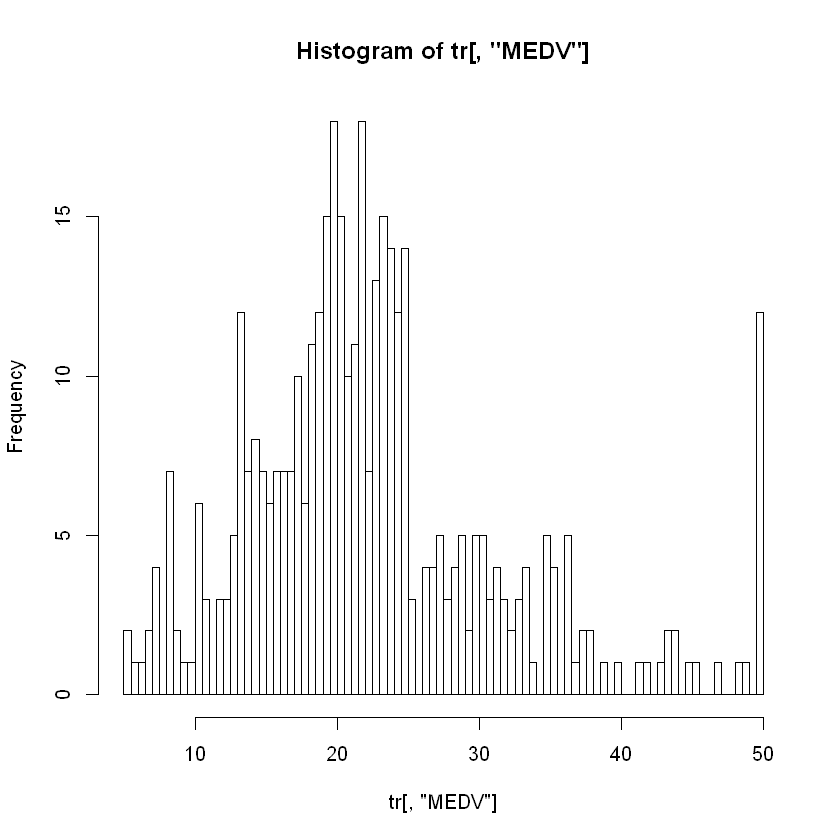

In [4]:
hist(tr[,'MEDV'], 100)

### 종속변수-독립변수 의 상관관계
### 'LSTA'변수가 -0.74로 가장 낮은 음의상관관계를 보임
### 'RM' 변수가 0.71로 가장 높은 음의상관관계를 보임

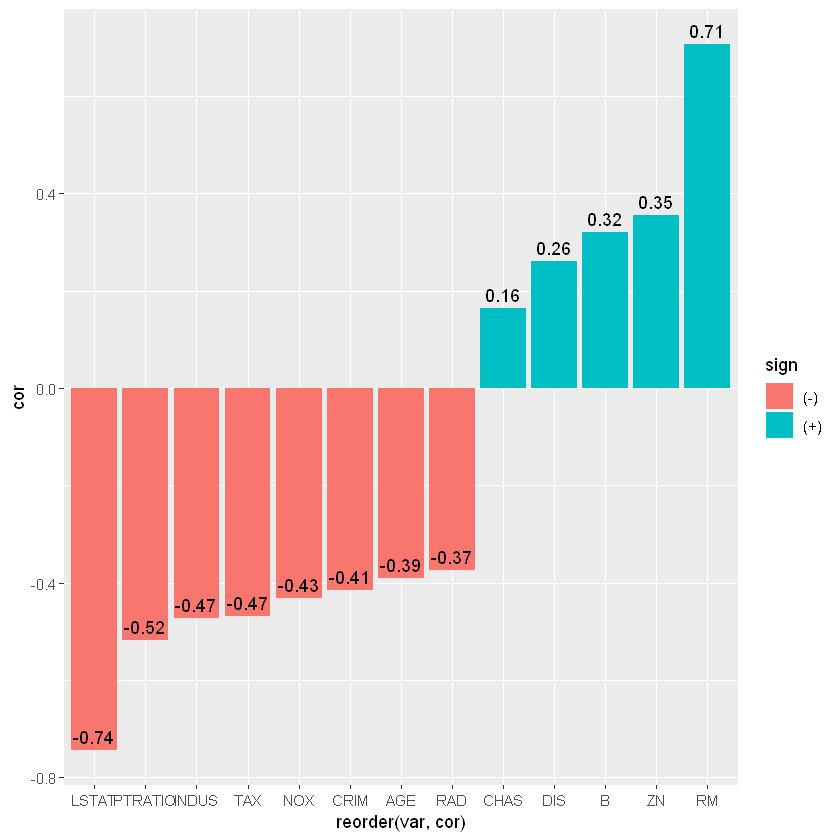

In [7]:
var_cor <- cor(tr[,-14],tr[,14])
var_cor_dat = data.frame(var = rownames(var_cor), cor= var_cor) %>%
    mutate(sign =ifelse(cor>=0, '(+)','(-)')) %>%
    arrange(desc(cor))
ggplot(data= var_cor_dat, aes(x=reorder(var,cor), y=cor)) +
    geom_bar(stat='identity', aes(fill = sign)) +
    geom_text(aes(label=round(cor, 2)), position=position_dodge(width=0.9), vjust= -0.5) 


### 변수 변환 진행
### 각 변수를 아래와 같은 변수로 치환
### 'x' ,'x^2', 'x^3', 'log(x)', 'sqrt(x)', '1/sqrt(x)', '1/x', '1/(x^2)', '1/(x^3)'
### 치환 이유는 비선형관계가 있는지 확인하고 이를 선형관계로 변형하고자 함

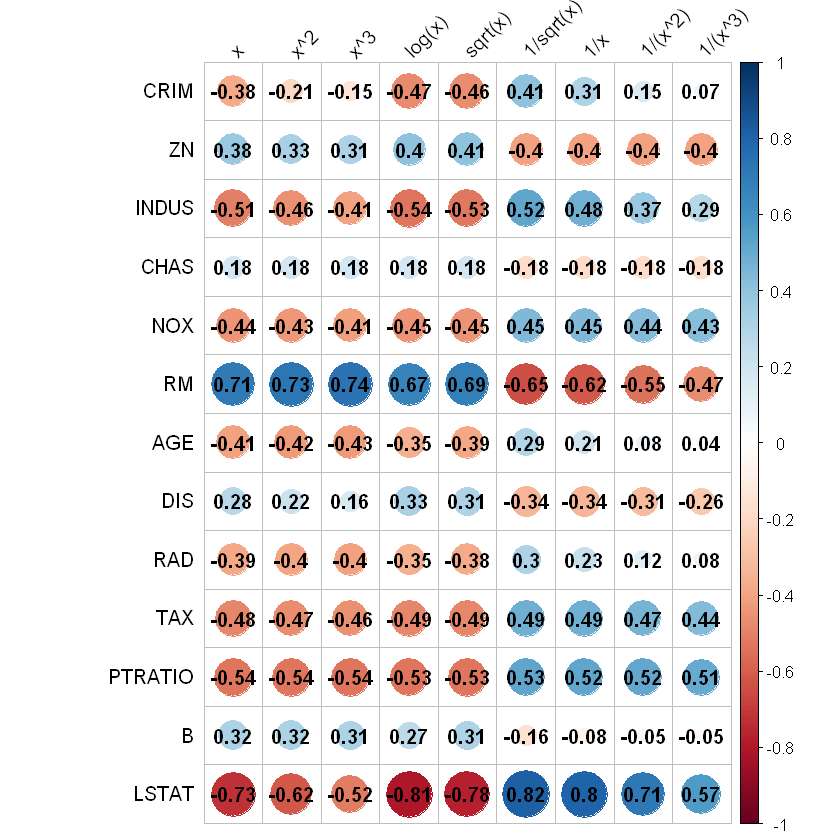

In [85]:
trans_var_cor <- function(x, var1, var2){        
    x <- x + (0.1^20)
    if(is.character(var1)){        
        var1 <- eval(parse(text = var1))        
    }    
    return(cor(var1,var2))
}

transformation <- c('x' ,'x^2', 'x^3', 'log(x)', 'sqrt(x)', '1/sqrt(x)', '1/x', '1/(x^2)', '1/(x^3)')

cor_list <- list()

for(tf in transformation){
    cor_list[[tf]] <- trans_var_cor(x=tr[,-14], tf, tr[,14])
}
cor_df <- as.data.frame(cor_list)
colnames(cor_df) <- transformation


corrplot(as.matrix(cor_df), 
         addCoef.col = "black", # Add coefficient of correlation
         tl.col="black", tl.srt=45, #Text label color and rotation
        
         )


### 치환된 변수와 종속변수간의 상관관계 확인
### 대부분 변수가 변환되며 상관관계가 더 높아짐

var,trans_var,cor,sign
LSTAT,1/sqrt(x),0.8162697,(+)
RM,x^3,0.7397797,(+)
TAX,1/sqrt(x),0.4899315,(+)
NOX,1/sqrt(x),0.4471174,(+)
ZN,sqrt(x),0.4056490,(+)
B,x^2,0.3180382,(+)
CHAS,x,0.1836911,(+)
DIS,1/x,-0.3360628,(-)
RAD,x^3,-0.4003430,(-)
AGE,x^3,-0.4257399,(-)


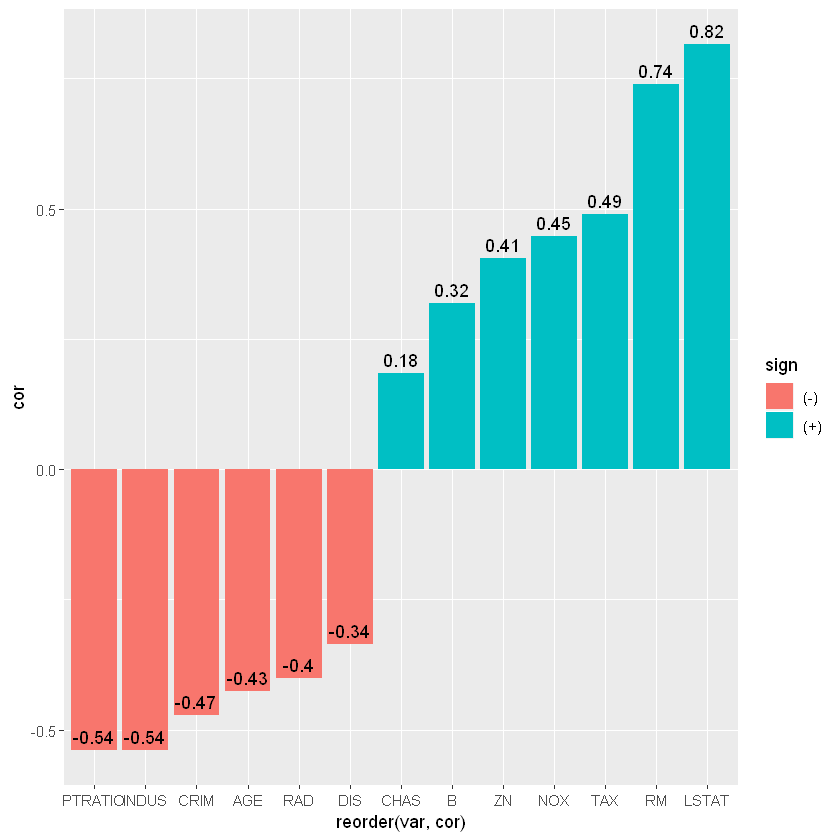

In [90]:
max_ind <- apply(abs(cor_df), 1, which.max)
trans_cor <- c()
trans_var <- c()
for(i in 1:length(max_ind)){    
    trans_var[i] <- transformation[max_ind[i]]
    trans_cor[i] <- cor_df[i,max_ind[i]]
}
trans_var_cor <- data.frame(var= rownames(cor_df), trans_var = trans_var, cor = trans_cor) %>%
            mutate(sign =ifelse(cor>=0, '(+)','(-)')) %>%
            arrange(desc(cor))
ggplot(data= trans_var_cor, aes(x=reorder(var,cor), y=cor)) +
    geom_bar(stat='identity', aes(fill = sign)) +
    geom_text(aes(label=round(cor, 2)), position=position_dodge(width=0.2), vjust= -0.5) 
trans_var_cor

### 종속변수와의 상관관계가 0.4 이상인 변수만을 선택
### 변환된 변수를 구하고 이를 'pre_train.csv', 'pre_test.csv' 파일로 저장

In [91]:
preprocessiong <- function(data, trans_var_cor){
    tmp <- data
    
    for(i in 1:nrow(trans_var_cor)){        
        var <- as.character(trans_var_cor[i,'var'])
        
        if(abs(trans_var_cor[i,'cor'])<0.4){                            
            tmp <- tmp %>% select(-var)
        }else{            
            x <- data[,var]            
            trans_var <- as.character(trans_var_cor[i,'trans_var'])
            trans_x <- eval(parse(text = trans_var))        
            tmp[[var]] <- trans_x    
        }
    }
    return(tmp)
}
train <- read.csv('data/train.csv')
test <- read.csv('data/test.csv')

pre_train <- preprocessiong(train,trans_var_cor)
pre_test <- preprocessiong(test,trans_var_cor)

write.csv(pre_train, 'data/pre_train.csv',row.names = FALSE)
write.csv(pre_test, 'data/pre_test.csv',row.names = FALSE)